In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [23]:
N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
nb_output = 2  # total number of output
D1 = 1  # first output
D2 = 1  # second output

# Evaluate on synthetic data

In [24]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

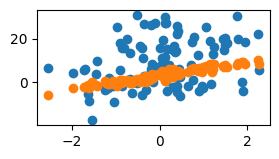

In [25]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

# Example Model

In [26]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output1_size, output2_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output1_size)
        self.fc3 = nn.Linear(hidden_size, output2_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out1 = self.fc2(out)
        out2 = self.fc3(out)
        return out1, out2

In [27]:
model = Net(Q, nb_features, D1, D2)

## Define task dependent log_variance

In [28]:
log_var_a = torch.zeros((1,), requires_grad=True)
log_var_b = torch.zeros((1,), requires_grad=True)

In [21]:
# Initialized standard deviations (ground truth is 10 and 1):
std_1 = torch.exp(log_var_a)**0.5
std_2 = torch.exp(log_var_b)**0.5
print([std_1.item(), std_2.item()])

[1.0, 1.0]


In [30]:
# get all parameters (model parameters + task dependent log variances)
params = ([p for p in model.parameters()] + [log_var_a] + [log_var_b])

In [31]:
#optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params)

## define loss criterion

In [34]:
def criterion(y_pred, y_true, log_vars):
  loss = 0
  for i in range(len(y_pred)):
    precision = torch.exp(-log_vars[i])
    diff = (y_pred[i]-y_true[i])**2.
    loss += torch.sum(precision * diff + log_vars[i], -1)
  return torch.mean(loss)

## Train the network

In [35]:
# convert data into torch from numpy array
X = X.astype('float32')
Y1 = Y1.astype('float32')
Y2 = Y2.astype('float32')

In [36]:
def shuffle_data(X,Y1,Y2):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], Y1[s], Y2[s]

In [37]:
## Train Network
loss_history = np.zeros(nb_epoch)

for i in range(1):

    epoch_loss = 0
    
    X, Y1, Y2 = shuffle_data(X, Y1, Y2)
    
    for j in range(N//batch_size):
        
        optimizer.zero_grad()
        
        inp = torch.from_numpy(X[(j*batch_size):((j+1)*batch_size)])
        target1 = torch.from_numpy(Y1[(j*batch_size):((j+1)*batch_size)])
        target2 = torch.from_numpy(Y2[(j*batch_size):((j+1)*batch_size)])
        
        out = model(inp)
        
        print(log_var_a)
        loss = criterion(out, [target1, target2], [log_var_a, log_var_b])
        print(log_var_a)
        
        epoch_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
   
    loss_history[i] = epoch_loss * batch_size / N    

tensor([0.], requires_grad=True)
tensor([0.], requires_grad=True)
tensor([0.0010], requires_grad=True)
tensor([0.0010], requires_grad=True)
tensor([0.0019], requires_grad=True)
tensor([0.0019], requires_grad=True)
tensor([0.0028], requires_grad=True)
tensor([0.0028], requires_grad=True)
tensor([0.0037], requires_grad=True)
tensor([0.0037], requires_grad=True)


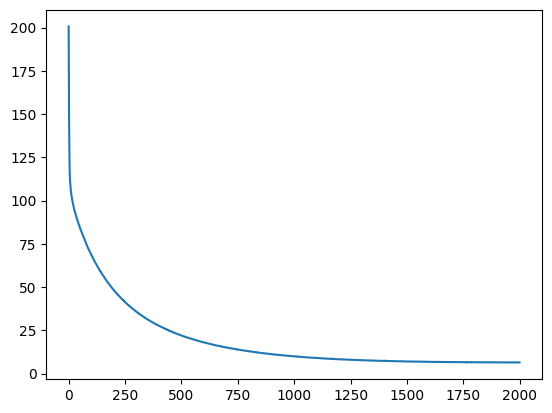

In [15]:
# plot loss history

pylab.plot(loss_history)

In [16]:
# Found standard deviations (ground truth is 10 and 1):
std_1 = torch.exp(log_var_a)**0.5
std_2 = torch.exp(log_var_b)**0.5
print([std_1.item(), std_2.item()])

[8.587499618530273, 0.9198130369186401]
